## Readout Tutorial

In [8]:
import matplotlib.pyplot as plt
import numpy as np

from qibolab.instruments.emulator.readout import ReadoutSimulator, lamb_shift
from qibolab.pulses import ReadoutPulse
from qibolab.qubits import Qubit


Let's initialize the required parameters for readout setup.

In [9]:
bare_resonator_frequency = 5.045e9
nshots = 100

SNR = 30  # dB
READOUT_AMPLITUDE = 1
NOISE_AMP = np.power(10, -SNR / 20)
AWGN = lambda t: np.random.normal(loc=0, scale=NOISE_AMP, size=len(t)) * 3e4

qb = Qubit(
    0,
    bare_resonator_frequency=bare_resonator_frequency,
    drive_frequency=3.99e9,
    anharmonicity=-263e6,
)
readout = ReadoutSimulator(
    qubit=qb,
    g=10e6,
    noise_model=AWGN,
    internal_Q=2.5e6,
    coupling_Q=6e4,
    sampling_rate=1966.08e6,
)


This part of the code demonstrates effect of state dependent dispersive shift on amplitude of reflected microwave from resonator.

- We first prepare a centre frequency for frequency sweeping, which may be modified during analysis, to search for the `dispersive shift`. 
- Note that dispersive shift and lamb shift depends on detuning (i.e.: `delta` = drive_frequency - bare_resonator_frequency).
- Lamb shifted frequency would then be shifted dispersively depending on ground_state or excited state of qubit.
- Fitting of |S21| is discussed here: https://github.com/qiboteam/qibocal/pull/917

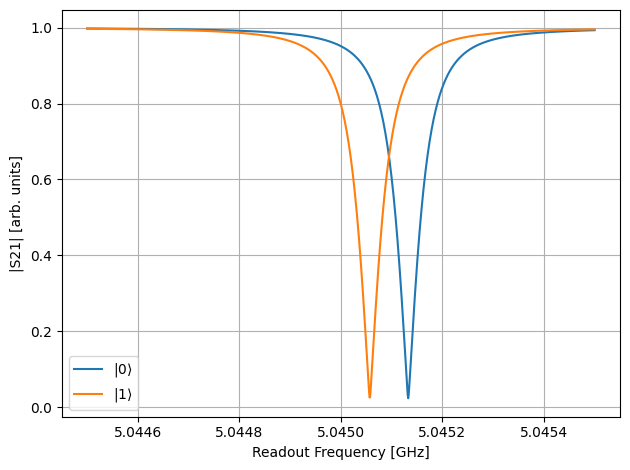

In [10]:
span = 1e6
center_frequency = bare_resonator_frequency
freq_sweep = np.linspace(center_frequency - span / 2, center_frequency + span / 2, 1000)
y_gnd = np.abs(readout.ground_s21(freq_sweep))
y_exc = np.abs(readout.excited_s21(freq_sweep))

freq_sweep /= 1e9
plt.plot(freq_sweep, y_gnd, label=r"$|0\rangle$")
plt.plot(freq_sweep, y_exc, label=r"$|1\rangle$")
plt.ylabel("|S21| [arb. units]")
plt.xlabel("Readout Frequency [GHz]")
plt.legend()
plt.grid()
plt.tight_layout()
# plt.savefig("S21.png", dpi=300)
plt.show()

#convert the frequency unit back to Hz
freq_sweep *= 1e9


This part of code demonstrates effect of state dependent dispersive shift on phase of reflected microwave from resonator. (for codomain of [-pi/2,pi/2])

- Note that we can always shift the phase/angle by pi, as a result of `arctan()`, as there are two angles resulting in the same `tan()` value.
- This means that we can shift the positive angles downwards by subtracting them with pi, resulting in codomain of [0,-2pi].
- For a clearer picture (using codomain of [0,-2pi] @see https://arxiv.org/pdf/1904.06560), we can see that the phase response of resonator shall be maximally separated when resonator is probed just in-between two qubit-state dependent resonance frequencies.

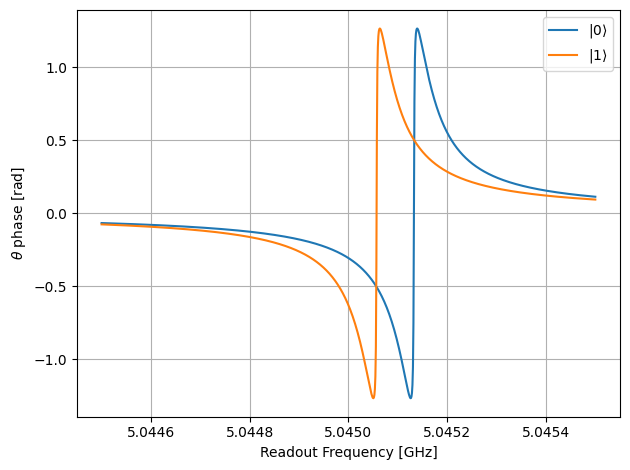

In [11]:
y_gnd1 = np.angle(readout.ground_s21(freq_sweep))
y_exc1 = np.angle(readout.excited_s21(freq_sweep))
freq_sweep /= 1e9
plt.plot(freq_sweep, y_gnd1, label=r"$|0\rangle$")
plt.plot(freq_sweep, y_exc1, label=r"$|1\rangle$")
plt.ylabel(r"$\theta$ phase [rad]")
plt.xlabel("Readout Frequency [GHz]")
plt.legend()
plt.grid()
plt.tight_layout()
# plt.savefig("phase.png", dpi=300)
plt.show()

This part of the code demonstrates the separation of V_I/V_Q data of reflected microwave on V_I/V_Q plane.

- We prepare a lamb shifted readout pulse frequency according to the first and second demonstration,so that we can inspect the phase response of resonator (being plotted on V_I/V_Q plane), which shall be maximally separated when resonator is probed just in-between two qubit-state dependent resonance frequencies.
- In other words, the data probed from resonator for particular qubit states should be well separated as demonstrated previously

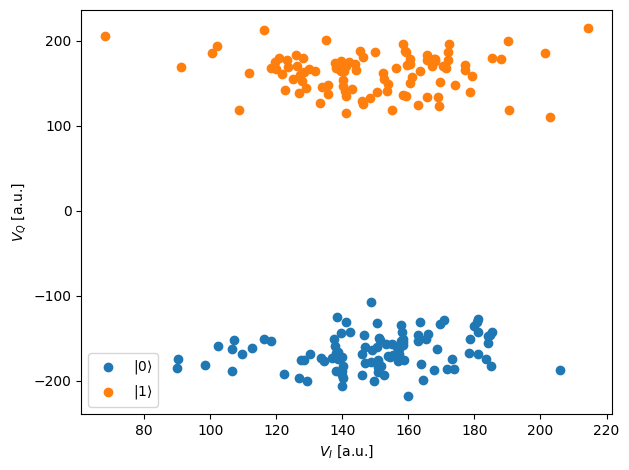

In [12]:
delta = qb.drive_frequency - qb.bare_resonator_frequency
ro_frequency = 5.0450e9 - lamb_shift(g=10e6, delta=delta)
ro_pulse = ReadoutPulse(
    start=0,
    duration=1000,
    amplitude=READOUT_AMPLITUDE,
    frequency=ro_frequency,
    shape="Rectangular()",
    relative_phase=0,
)

rgnd = [readout.simulate_ground_state_iq(ro_pulse) for k in range(nshots)]
rexc = [readout.simulate_excited_state_iq(ro_pulse) for k in range(nshots)]
plt.scatter(np.real(rgnd), np.imag(rgnd), label=r"$|0\rangle$")
plt.scatter(np.real(rexc), np.imag(rexc), label=r"$|1\rangle$")
# when we set NOISE_AMP to zero, using the follow axes limits allow us to see the maximally separated data
# plt.xlim([0,250])
# plt.ylim([-250,250])
plt.xlabel(r"$V_I$ [a.u.]")
plt.ylabel(r"$V_Q$ [a.u.]")
plt.legend()
plt.tight_layout()
# plt.savefig("IQ_readout.png", dpi=300)
plt.show()
